# Abstract

We will be providing a platform with summaries of papers relevant to Covid-19 risk factors(such as hypertension, elderly age, etc.) While the extraction of succint findings from papers would be helpful in itself, we believe that  context into the methods used to arrive at these findings would also very relevant for researchers.

Here is a screenshot of the platform that we have:

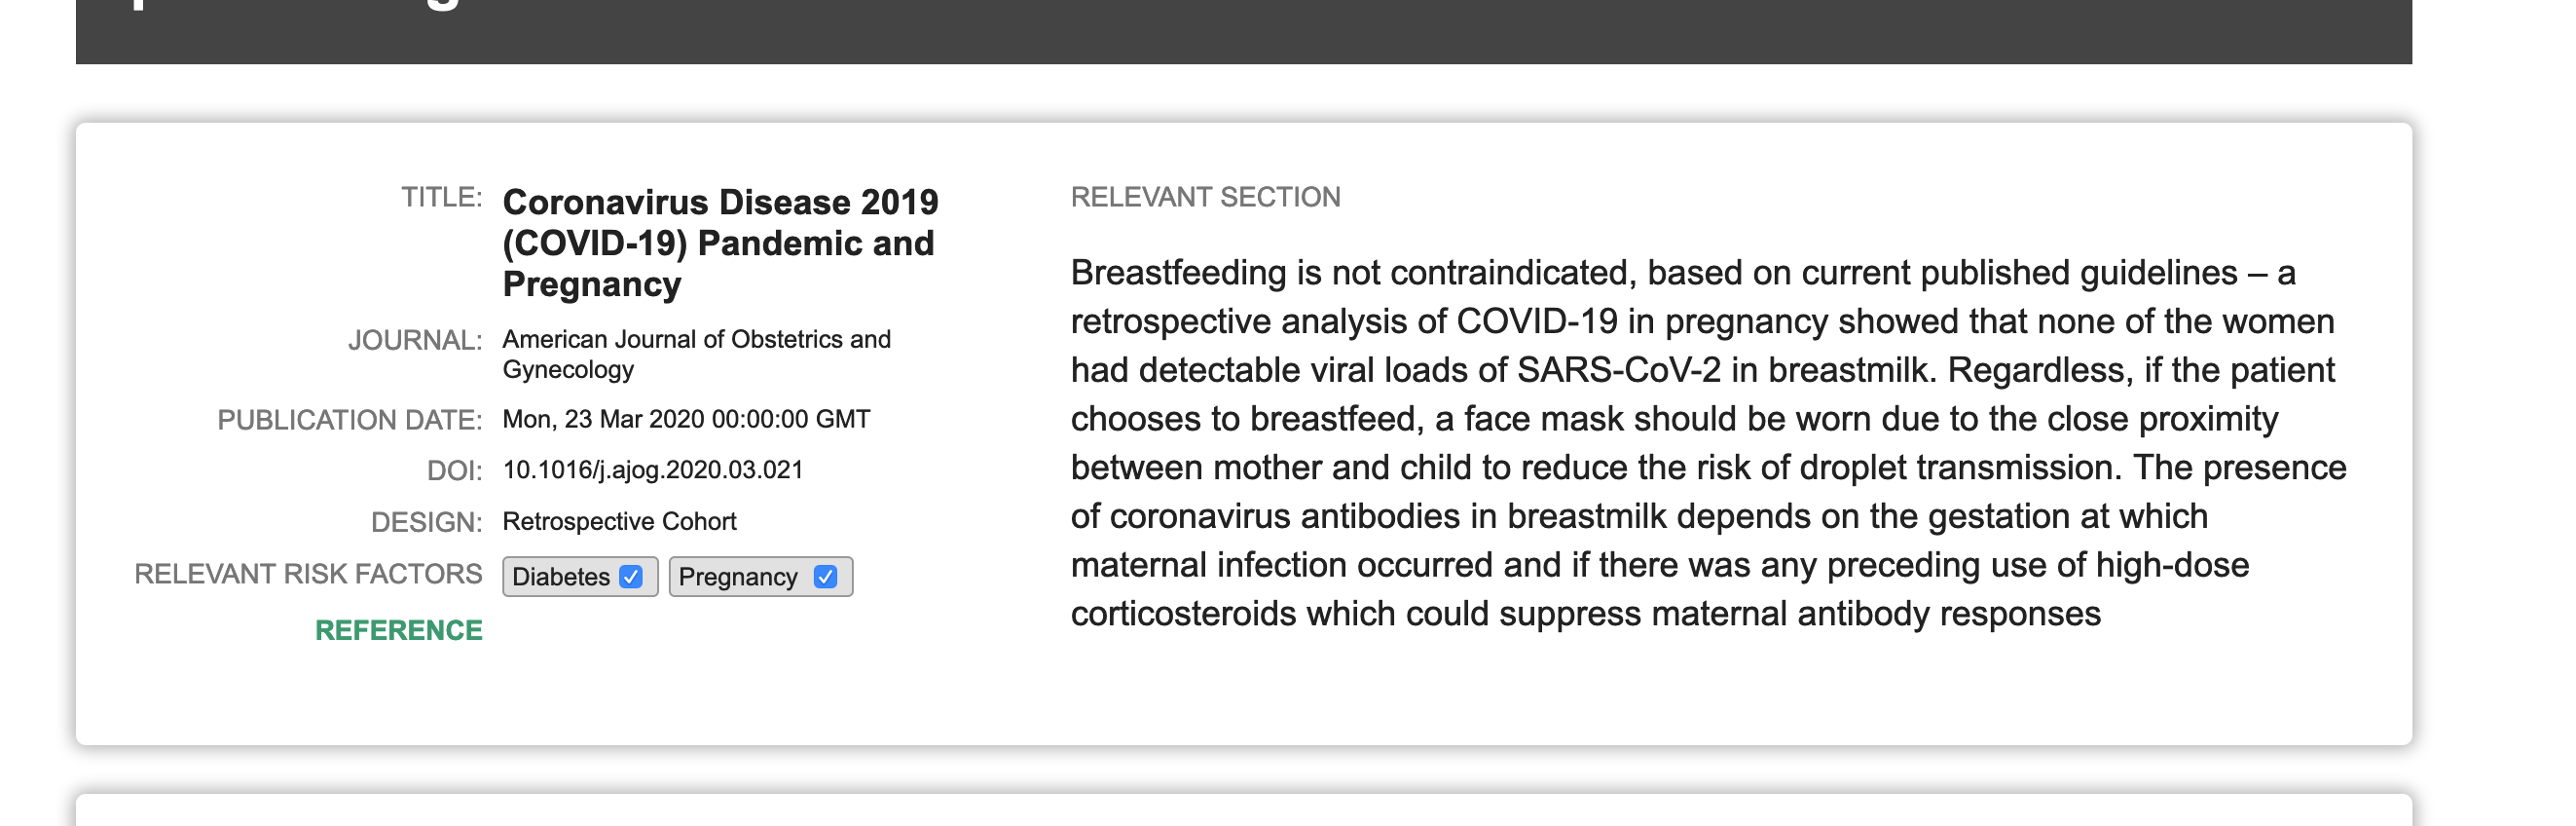

In [2]:
from IPython.display import Image
#Image("../input/platformsample/platform_sample.png")
Image('platform_sample.png')

We are a team of data scientists and engineers, and while we are familiar with our tools, what we need is help from the epidimiology community. We have taken an unsupervised approach, so the precision of our extraction might not always be optimal. In order to make improvements, we need feedback from medical professionals. 

This platform has the potential to be an extremely customizable and useful tool for researchers. We need 10 minutes of your time where you will be labelling our excerpts as "relevant" or "not relevant". All help will be greatly appreciated.

# Approach
Here is an outline for the implementation of our platform:
- Extract paper jsons - 50k + entries
- Filter for corona references(covid, cov-2, novel coronavirus, etc.)
- Obtain and stem list of risk factors(eg. hypertension) and study designs(eg. meta analysis)
    - List of risk factors and study designs obtained from [crowdsourced medical dictionary](https://docs.google.com/spreadsheets/d/1t2e3CHGxHJBiFgHeW0dfwtvCG4x0CDCzcTFX7yz9Z2E/edit#gid=1217643351)
- Extract sections in paper bodies that have mention the design of the study
- Extract the sections that have mentions of a risk factor
- Append each extraction to a dataframe alongside the `paper_id`.
- Join with metadata on `paper_id`
- Filter for articles published on 2019 or after
- Filter out noise:
    - Any sections that are for references purpose only
    - Any sections with an extremely high number of hyperlinks
- Summarize papers with relevant sections using `Bert-Extractive-Summarizer` and `SciBert`

In [37]:
import os
import re
import sys
import json
import glob

import numpy as np
import pandas as pd

from pprint import pprint
from copy import deepcopy
from datetime import datetime
from tqdm.notebook import tqdm

### Global variables

In [4]:
#root = "../input/CORD-19-research-challenge/"
root = '../data/'

design_list = [
    'retrospective cohort', 'cross-sectional case-control',
    'cross sectional case control', 'prevalence survey', 'systematic review ',
    ' meta-analysis', ' meta analysis', 'matched case-control',
    'matched case control', 'medical record review',
    'observational case series', 'time series analysis',
    'pseudo-randomized controlled trials',
    'pseudo randomized controlled trial', 'randomized controlled trials',
    'randomized controlled trial', 'retrospective analysis',
    'retrospective study', 'retrospective studies'
]

risk_factors = [
    'diabete', 'hypertension', 'heart disease', 'cancer', 'smoking',
    'history of lung', 'local climate', 'elderly', 'children',
    'immune compromised ', 'age deciles', 'race', 'ethnicity', 'education',
    'income', 'insurance', 'housing', 'immigration', 'prison inmate',
    'mental hospital inpatients', 'long-term care facility resident',
    'long term care'
    'health worker', 'first responder', 'hospital staff', 'nursing home',
    'prison', 'staff', 'pregnancy', 'baby', 'enfant', 'pulm', 'neonates'
]

covid_keywords = ['covid-19', 'hcov-19', 'cord-19' ,'2019-ncov', 'wuhan coronavirus', 'sars-cov-2', 'covid']

In [5]:
# Find all .json files in data(they're papers)
paper_filenames = glob.glob(f'{root}/**/*.json', recursive=True)

### Loading metadata 

In [44]:
metadata_df = pd.read_csv(
    root + 'metadata.csv',
    parse_dates=['publish_time'],
    keep_default_na=False,
    usecols=['title', 'sha', 'abstract', 'publish_time', 'journal'])

#### Filtering for papers published on 2019 and after

In [45]:
metadata_df = metadata_df[metadata_df['publish_time'] >= datetime(2019, 1, 1)]

#### Filtering for papers with references to covid-19

In [46]:
metadata_df = metadata_df[metadata_df['abstract'].apply(
    lambda x: any(key in x.lower() for key in covid_keywords))]

In [47]:
metadata_df.shape

(2090, 5)

In [48]:
relevant_papers = metadata_df['sha'].values

### Extract snippets with mentions of study designs

In [57]:
design_sections = []

for j  in tqdm(range(len(relevant_papers))):
    for i in range(0, len(paper_filenames)):
        paper_filename = os.path.basename(paper_filenames[i])
        paper_filename = "".join(paper_filename.split(".")[:-1])
        if relevant_papers[j] == paper_filename:
            with open(paper_filenames[i], "r") as infile:
                filetext = infile.read()
            with open(paper_filenames[i]) as data:
                data = json.load(data)
                pattern = r'"text": "([^"]*(%s)[^"]*)((?!"section").)*"section": "([^"]*)"' % "|"\
                        .join(design_list)
                regex = re.compile(pattern, re.DOTALL)
                results = regex.findall(filetext.lower())
                if len(results) > 0:
                    combined_results = []
                    seen = set()

                    for result in results:
                        if result[3] in seen:
                            continue
                        else:
                            combined_results.append(result)
                            seen.add(result[3])
                    for match in results:
                        design_sections.append(
                            [data['paper_id'], match[3], match[1], match[0]])

In [58]:
design_df = pd.DataFrame(design_sections, columns = ['doc_id', 'section', 'study_design', 'relevant_section'])
sec = [sec.lower() for sec in design_df['section']]

In [59]:
design_df.shape

(403, 4)

### Investigating mentions of risk factors

In [60]:
risk_sections = []
for i in range(0, len(design_df['relevant_section'])):
    text = design_df.loc[i, 'relevant_section']
    risk = risk_factors
    ri_list = [re.findall(ri.lower(), text) for ri in risk]
    for ri in ri_list:
        if ri != []:
            risk_sections.append([
                design_df.loc[i, 'doc_id'], ri, text,
                design_df.loc[i, 'section'],
                design_df.loc[i, 'study_design']
            ])

In [62]:
risk_df = pd.DataFrame(sec_risk, columns =['doc_id', 'risk', 'relevant_section', 'section', 'study_design'])
set(risk_df['study_design'])

{' meta-analysis',
 'matched case-control',
 'medical record review',
 'randomized controlled trial',
 'randomized controlled trials',
 'retrospective analysis',
 'retrospective cohort',
 'retrospective study',
 'systematic review '}

#### Study Designs Cleanup
The next cell will clean up instances where the same study name has beem repeated but with different spellings(Example: `randomized controlled trial` vs `randomized controlled trials`)

In [66]:
risk_df['study_design'].replace('retrospective analysis','retrospective cohort', inplace = True)
risk_df['study_design'].replace(['retrospective studies','retrospective study'],'retrospective cohort', inplace = True)
risk_df['study_design'].replace('randomized controlled trial','randomized controlled trials', inplace = True)

set(risk_df['study_design'])

{' meta-analysis',
 'matched case-control',
 'medical record review',
 'randomized controlled trials',
 'retrospective cohort',
 'systematic review '}

In [ ]:
risk_df.to_csv('output/risk_df.csv')